In [76]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

np.set_printoptions(precision=4)

In [77]:
data = pd.read_csv('final_df.csv')

In [78]:
data.head()

,season,round,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,grid,podium,...,constructor_minardi,constructor_prost,constructor_red_bull,constructor_renault,constructor_sauber,constructor_team_lotus,constructor_toro_rosso,constructor_toyota,constructor_tyrrell,constructor_williams
0,1983,1,False,False,True,False,False,keke_rosberg,1,15,...,0,0,0,0,0,0,0,0,0,1
1,1983,1,False,False,True,False,False,prost,2,6,...,0,0,0,1,0,0,0,0,0,0
2,1983,1,False,False,True,False,False,tambay,3,4,...,0,0,0,0,0,0,0,0,0,0
3,1983,1,False,False,True,False,False,piquet,4,1,...,0,0,0,0,0,0,0,0,0,0
4,1983,1,False,False,True,False,False,warwick,5,7,...,0,0,0,0,0,0,0,0,0,0


## Classification

In [79]:
df = data.copy()
df.podium = df.podium.map(lambda x: 1 if x == 1 else 0)

train = df[df.season <2019]
X_train = train.drop(['driver', 'podium'], axis = 1)
y_train = train.podium

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

In [80]:
#Custom function for the score classification model, the driver with the highest probability of winning will be mapped as the winner
def score_classification(model):
    score = 0
    for circuit in df[df.season == 2019]['round'].unique():

        test = df[(df.season == 2019) & (df['round'] == circuit)]
        X_test = test.drop(['driver', 'podium'], axis = 1)
        y_test = test.podium

        #scaling
        X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

        # make predictions
        prediction_df = pd.DataFrame(model.predict_proba(X_test), columns = ['proba_0', 'proba_1'])
        prediction_df['actual'] = y_test.reset_index(drop = True)
        prediction_df.sort_values('proba_1', ascending = False, inplace = True)
        prediction_df.reset_index(inplace = True, drop = True)
        prediction_df['predicted'] = prediction_df.index
        prediction_df['predicted'] = prediction_df.predicted.map(lambda x: 1 if x == 0 else 0)

        score += precision_score(prediction_df.actual, prediction_df.predicted)

    model_score = score / df[df.season == 2019]['round'].unique().max()
    return (model_score, prediction_df)

In [81]:
comparison_dict ={'model':[],
                  'params': [],
                  'score': []}

## Logistic Regression

In [83]:
# Logistic Regression

params={'penalty': ['l1', 'l2'],
        'solver': ['saga', 'liblinear'],
        'C': np.logspace(-3,1,20)}

for penalty in params['penalty']:
    for solver in params['solver']:
        for c in params['C']:
            model_params = (penalty, solver, c)
            model = LogisticRegression(penalty = penalty, solver = solver, C = c, max_iter = 10000)
            model.fit(X_train, y_train)
            
            model_score = score_classification(model)
        
            comparison_dict['model'].append('logistic_regression')
            comparison_dict['params'].append(model_params)
            comparison_dict['score'].append(model_score)

## Random Forest Classifier

In [31]:
# Random Forest Classifier

params={'criterion': ['gini', 'entropy'],
        'max_features': [0.8, 'auto', None],
        'max_depth': list(np.linspace(5, 55, 26)) + [None]}

for criterion in params['criterion']:
    for max_features in params['max_features']:
        for max_depth in params['max_depth']:
            model_params = (criterion, max_features, max_depth)
            model = RandomForestClassifier(criterion = criterion, max_features = max_features, max_depth = max_depth)
            model.fit(X_train, y_train)
            
            model_score = score_classification(model)
            
            comparison_dict['model'].append('random_forest_classifier')
            comparison_dict['params'].append(model_params)
            comparison_dict['score'].append(model_score)

## Neural Network

In [32]:
# Neural network

#Please note that the NN classifier takes around 4+ hours to run due to the grid search for the hyperparameter.
#The best hyperparameters can be found in the last table in the notebook.
#If you wish to re-run the code please use those.

params={'hidden_layer_sizes': [(80,20,40,5), (75,25,50,10)], 
        'activation': ['identity', 'logistic', 'tanh', 'relu'], 
        'solver': ['lbfgs', 'sgd', 'adam', 'logistic'], 
        'alpha': np.logspace(-4,2,20)} 


for hidden_layer_sizes in params['hidden_layer_sizes']:
    for activation in params['activation']:
        for solver in params['solver']:
            for alpha in params['alpha']:
                model_params = (hidden_layer_sizes, activation, solver, alpha )
                model = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
                                      activation = activation, solver = solver, alpha = alpha, random_state = 1)
                model.fit(X_train, y_train)

                model_score = score_classification(model)

                comparison_dict['model'].append('neural_network_classifier')
                comparison_dict['params'].append(model_params)
                comparison_dict['score'].append(model_score)
                
prediction=score_classification(model)

### Example of prediction output

In [33]:
prediction

,proba_0,proba_1,actual,predicted
0,0.420175,0.579825,1,1
1,0.700513,0.299487,0,0
2,0.951893,0.048107,0,0
3,0.961263,0.038737,0,0
4,0.988020,0.011980,0,0
5,0.990970,0.009030,0,0
6,0.991762,0.008238,0,0
7,0.996645,0.003355,0,0
8,0.996676,0.003324,0,0
9,0.999016,0.000984,0,0


In [34]:
pd.DataFrame(comparison_dict).groupby('model')['score'].max()

model
logistic_regression          0.571429
neural_network_classifier    0.571429
random_forest_classifier     0.523810
Name: score, dtype: float64

In [11]:
best_models=pd.DataFrame(pd.DataFrame(comparison_dict).groupby('model')['score'].max())
best_models.reset_index(inplace=True)
best_models

,model,score
0,logistic_regression,0.571429
1,neural_network_classifier,0.571429
2,random_forest_classifier,0.476190


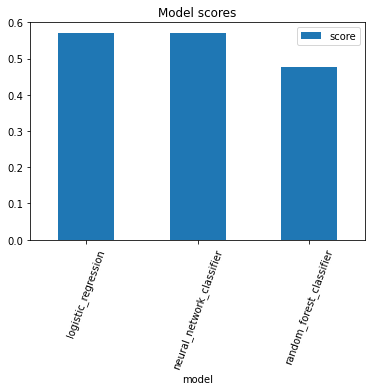

In [24]:
import matplotlib.pyplot as plot
best_models.plot.bar(x="model", y="score", rot=70, title="Model scores");

plot.show(block=True)

In [12]:
All_models=pd.DataFrame(comparison_dict)

In [13]:
Best_Model_info=pd.merge(best_models,All_models,how='left',left_on=['model','score'],right_on=['model','score'])
Best_Model_info.drop_duplicates(keep=False,inplace=True)

In [14]:
#Please note that the NN classifier takes around 4+ hours to run and therefore only the best hyperparameters were left for it but the original function can be found below (with the entire grid search.)

Best_Model_info

,model,score,params
0,logistic_regression,0.571429,"(l1, liblinear, 1.438449888287663)"
1,logistic_regression,0.571429,"(l1, liblinear, 2.3357214690901213)"
2,logistic_regression,0.571429,"(l1, liblinear, 3.792690190732246)"
3,logistic_regression,0.571429,"(l1, liblinear, 6.158482110660261)"
4,logistic_regression,0.571429,"(l1, liblinear, 10.0)"
5,logistic_regression,0.571429,"(l2, liblinear, 2.3357214690901213)"
6,logistic_regression,0.571429,"(l2, liblinear, 3.792690190732246)"
7,logistic_regression,0.571429,"(l2, liblinear, 6.158482110660261)"
8,logistic_regression,0.571429,"(l2, liblinear, 10.0)"
9,neural_network_classifier,0.571429,"((75, 25, 50, 10), identity, lbfgs, 0.01623776..."
